In [1]:
%matplotlib inline

# Load libraries
import numpy as np
import scikitplot
import cv2 # See ReadMe for instructions how to install module
import glob
import matplotlib.pyplot as plt
import skimage.transform as sktransform
import operator
from sklearn.metrics import accuracy_score
from skimage.color import rgb2gray
from skimage import feature
from skimage import exposure
from scipy import ndimage
from skimage import filters
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC # Import Support Vector Classifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import math
import scikitplot as skplt

/anaconda3/envs/py3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
# DEFECTIVE = 1, NON-DEFECTIVE = 0
# Original Image size : 4000x3000

#Read Images
boxes = [] # Declare array storing images
boxes_type = [] # Declare array storing image type, Defective vs Non-defective
files = glob.glob ("/Users/maricrissilayan/Desktop/box-images/OK/*.JPG") # Image path of Non Defective boxes
for myFile in files:
    img = cv2.imread (myFile)
    image = cv2.resize(img,(400,300),interpolation=cv2.INTER_AREA) # Re-scale image to ~10% of its original size
    boxes.append (image)
    boxes_type.append(0) # Assigning 0 for images of Non-defective boxes 
files = glob.glob ("/Users/maricrissilayan/Desktop/box-images/NG/*.JPG") # Image path of Defective boxes
for myFile in files:
    img = cv2.imread (myFile)
    image = cv2.resize(img,(400,300),interpolation=cv2.INTER_AREA) # Re-scale image to ~10% of its original size
    boxes.append (image)
    boxes_type.append(1)# Assigning 1 for images of Defective boxes 
    
boxes = np.array(boxes,dtype='float32') # Assigning value type as float32 for better accuracy of values
boxes_type = np.array(boxes_type,dtype='float64')

# save numpy array as .npy formats
np.save('boxes',boxes) # Shape as 373 x 300 x 400 x 3
np.save('boxes_type',boxes_type) # 1D array with 373 rows

In [3]:
boxes_hog=[] # Declare array containing features of the box images
boxes_lbp=[] # Declare array containing features of the box images

kernel = np.ones((5,5), np.uint8) # Declaring kernel of matrix size 5 for gaussian filter

for i in list(range(373)): # For loop for image processing of the 373 images
    gray_image = rgb2gray(boxes[i]) # Convert image from RGB to grayscale
    im_noise = ndimage.gaussian_filter(gray_image,2) # Using Gaussian filter for noise reduction 
    pmin, pmax = np.percentile(im_noise, (5, 95)) # Deriving parameters for image enhancement
    img_enhanced = exposure.rescale_intensity(im_noise, in_range=(pmin, pmax)) # Applying contrast enhancement 
    edge_x = cv2.Sobel(img_enhanced,cv2.CV_64F,1,0,ksize=3) # Applying horizontal Sobel filter
    edge_y = cv2.Sobel(img_enhanced,cv2.CV_64F,0,1,ksize=3) # Applying vertical Sobel filter   
    edge = np.sqrt(edge_x**2 + edge_y**2) # Combining the results of horizontal and vertical sobel filter
    img_erosion = cv2.erode(edge, kernel, iterations=1) # Applying erosion to remove resulting white noises
    img_dilation = cv2.dilate(img_erosion, kernel, iterations=1) # Applying dilation to counter shinking of the box
    hog = feature.hog(img_dilation, orientations=9, pixels_per_cell=(5, 5), # Deriving HoG features of the detected box
        cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")    
    lbp=feature.local_binary_pattern(img_dilation, P=8, R=2, method='uniform')
    boxes_hog.append(hog)
    boxes_lbp.append(lbp)
boxes_hog = np.array(boxes_hog,dtype='float32') # Array containing HoG features of the images, 373 x 167,796
boxes_lbp = np.array(boxes_lbp,dtype='float32') # Array containing HoG features of the images, 373 x 300 x 400
boxes_lbp = np.reshape(boxes_lbp,[boxes_lbp.shape[0],boxes_lbp.shape[1]*boxes_lbp.shape[2]]) #reshaping array, 373 x 120,000


In [4]:
print(boxes_lbp.shape)
print(boxes_hog.shape)
boxes_feats = np.concatenate((boxes_lbp, boxes_hog), axis=1)
print(boxes_feats.shape)

(373, 120000)
(373, 167796)
(373, 287796)


In [5]:
#Hold-out Test Data Set at 30%
X_train, X_test, y_train, y_test = train_test_split(boxes_feats, boxes_type, test_size=0.2, random_state=54321)
print(X_train.shape, y_train.shape) # Dimension of the training dataset
print(X_test.shape, y_test.shape) # Dimension of the test data set

(298, 287796) (298,)
(75, 287796) (75,)


In [6]:
#Data Normalization
scaler = StandardScaler() # Initializing scaler 
scaler.fit(X_train) # Fitting on training set only.
X_train_st = scaler.transform(X_train) # Transforming values so that distribution is normal(0,1)
X_test_st = scaler.transform(X_test) # Transforming values so that distribution is normal(0,1)

In [57]:
# Dimension Reduction using Principal Component Analysis, Current Dimension = 287,796
#pca = PCA(n_components=90) # Inializing PCA at degree of confidence 95%
pca = PCA(95)
pca.fit(X_train_st) # Fitting PCA on the training dataset

X_train_pca = pca.transform(X_train_st) # Fitting PCA on the datasets
X_test_pca = pca.transform(X_test_st)

In [45]:
C_range = np.logspace(-2, 10, 13) # Range for C
gamma_range = np.logspace(-9, 3, 13) #Range for gamma
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2) # Stratified C-V
def max_CV (X_train_pca, y_train):
    grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv) #Gridsearch
    grid.fit(X_train_pca, y_train)

    print("The best parameters are %s with a score of %0.2f" # Best parameter for optimum performance
          % (grid.best_params_, grid.best_score_))

In [46]:
#Repeated running of Grid Search CV for 1000 times revealed that best parameters ar 10 and 0.5 majority of the times
h=1
for h in range(1): # Set to higher number for verification
    max_CV(X_train_pca, y_train)
    h += 1
print("Number of Iterations: " , h)   

The best parameters are {'C': 10.0, 'gamma': 1e-06} with a score of 0.91
Number of Iterations:  1


In [70]:
# Create SVM classifier object, fitting best parameters
abc = SVC(C=10, gamma=0.000001, probability=True,kernel="rbf", random_state=2154321)
# Train AdaBoost Classifier
model = abc.fit(X_train_pca, y_train)
# Predict the response for test dataset
y_pred = model.predict(X_test_pca)

cf=metrics.confusion_matrix(y_test, y_pred)
print(cf)
TP = cf[1][1]
TN = cf[0][0]
FP = cf[0][1]
FN = cf[1][0]
print("------------------")
print("True Positive: ", TP)
print("True Negative: ", TN)
print("False Positive: ", FP)
print("False Negative: ", FN)
print("------------------")

[[35  5]
 [ 4 31]]
------------------
True Positive:  31
True Negative:  35
False Positive:  5
False Negative:  4
------------------


In [71]:
print("Accuracy: %0.2f" % (metrics.accuracy_score(y_test, y_pred)*100))
print("Precision: %0.2f" % (metrics.precision_score(y_test, y_pred)*100))

print("Recall | Sensitivity | True Positives ", TP/(TP+FN)*100)
print("Specificity | True Negatives ", TN/(TN+FP)*100)

print("Cohen Kappa Score: %0.2f" % (metrics.cohen_kappa_score(y_test, y_pred)*100))
print("Hamming Loss: %0.2f" % (metrics.hamming_loss(y_test, y_pred)*100))
print("Hinge Loss: %0.2f" % (metrics.hinge_loss(y_test, y_pred)*100))
print("Jaccard Similarity Score: %0.2f" % (metrics.jaccard_similarity_score(y_test, y_pred)*100))
print("Log Loss: %0.2f" % (metrics.log_loss(y_test, y_pred)))
print("Matthews Correlation Coefficient: %0.2f" % (metrics.matthews_corrcoef(y_test, y_pred)*100))
print("Zero One Loss: %0.2f" % (metrics.zero_one_loss(y_test, y_pred)*100))

Accuracy: 88.00
Precision: 86.11
Recall | Sensitivity | True Positives  88.57142857142857
Specificity | True Negatives  87.5
Cohen Kappa Score: 75.94
Hamming Loss: 12.00
Hinge Loss: 65.33
Jaccard Similarity Score: 88.00
Log Loss: 4.14
Matthews Correlation Coefficient: 75.96
Zero One Loss: 12.00


/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_learning_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.estimators.plot_learning_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


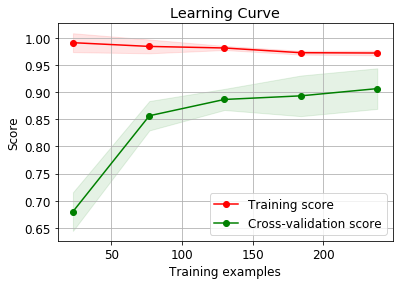

In [72]:
scikitplot.plotters.plot_learning_curve(model, X_train_pca, y_train, title='Learning Curve', cv=cv, train_sizes=None, n_jobs=1, 
                                        scoring=None, ax=None, figsize=None, title_fontsize='large', 
                                        text_fontsize='medium')


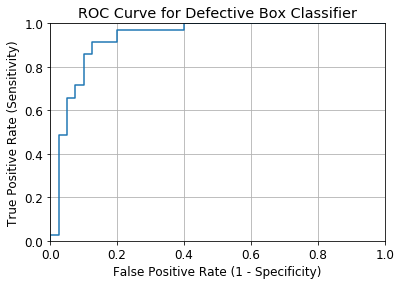

In [51]:
y_pred_prob = model.predict_proba(X_test_pca)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC Curve for Defective Box Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

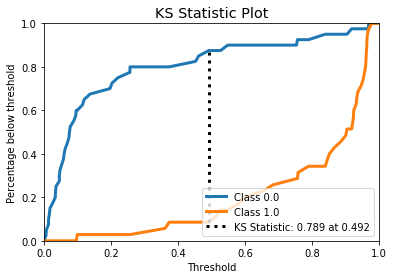

In [52]:
y_pred_prob = model.predict_proba(X_test_pca)
from scikitplot.metrics import plot_ks_statistic

plot_ks_statistic(y_test, y_pred_prob, title='KS Statistic Plot', 
                          ax=None, figsize=None, title_fontsize='large', text_fontsize='small')

/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


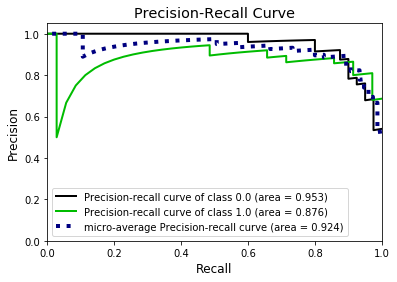

In [53]:
from scikitplot.metrics import plot_precision_recall_curve
plot_precision_recall_curve(y_test, y_pred_prob, title='Precision-Recall Curve', 
                            ax=None, figsize=None, title_fontsize='large', text_fontsize='small')

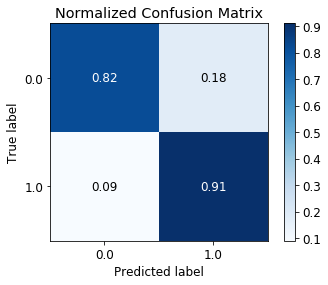

/anaconda3/envs/py3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


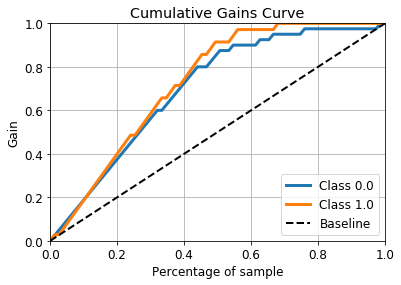

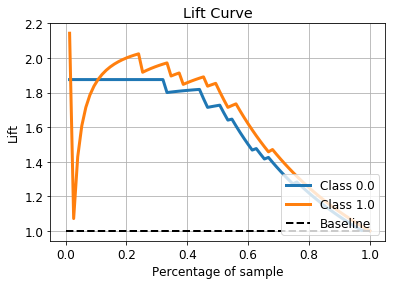

In [54]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

skplt.metrics.plot_cumulative_gain(y_test, y_pred_prob)
plt.show()

skplt.metrics.plot_lift_curve(y_test, y_pred_prob)
plt.show()